# Simple modeling of Pay-it-backwards over multiple transactions

Creating a model of several transactions using the pay-it-backward model to show cumulative cash flows over time for various starting prices and turns (sales) of the digital asset.

## This simulates the sale of one non-fungible digital asset over X number of "turns" through multiple (unique) owners.

In [1]:
# Number of times the asset exchanges hands (i.e. how many times to run the simulation)
turns = 10

# Assuming fixed price for simple modeling
# A bidding model would allow the market to decied on actual price of a specific bootleg
# Questions about this bidding model...
token_price = 100.00


# Token Registry... just a simple ledger
Sorta maybe kinda works like a block chain ledger. It just knows transactions but it does embed 'owner' objects for convenience. 

In [2]:
# Token registery for a single NFT asset
class TokenRegistry:
    def __init__(self):
        self._registry = {}
    
    def sellTo(self, new_owner, salePrice):
        # New owner pays the price first
        new_owner.pay(-token_price)
        
        # That payment is sent to all existing owners by share
        self.issuePayouts(salePrice)
        
        # Add the new owner to the list and redistribute
        self.addOwner(new_owner)
        
    def addOwner(self, owner):
        self._registry[owner.name] = {
            "owner": owner,
            "share": self._newOwnerShareRate()
        }
        # Set equal distrbution of rates
        self.redistribute()
    
    def redistribute(self):
        for owner_name, reg_entry in self._registry.items():
            share_rate = self._newOwnerShareRate()
            reg_entry['share'] = share_rate
            print("Set rate {:.3f}% for {:s}".format(share_rate * 100, owner_name))
        return None
        
    def issuePayouts(self, salePrice):
        for _, reg_entry in self._registry.items():
            payout = salePrice * reg_entry['share']
            owner = reg_entry['owner']
            owner.pay(payout)
            print("Paid out ${:.6f} to {:s} (total earned ${:.6f})".format(payout, owner.name, owner.balance))
        return None
    
    @property
    def registry(self):
        return self._registry
            
     
    # Everyone gets an equal share of the pie
    def _newOwnerShareRate(self):
        reg_len = len(self._registry)
        if reg_len > 0:
            return(1.0/reg_len)
        else:
            return(1.0)

# Simple model of the token owner
Something that could hold a payment ledger and represent the owner of the asset

In [3]:
class TokenOwner:
    def __init__(self, name):
        self._name = name
        self._payments = []
        
    @property
    def name(self):
        return self._name
    
    @property
    def balance(self):
        return sum(self._payments)
    
    @property
    def payments(self):
        return self._payments
    
    def pay(self, amount):
        self._payments.append(amount)
        




# Running the simple simulation
The output shows each turn and how the simple asset allocation works out for the parties involved. I'm not sure that it does with fixed prices. 

In [4]:
bleg = TokenRegistry()

def turnToken(token, turn, owner):
    print("New sale to {:s}".format(owner.name))
    token.sellTo(owner, token_price)

# Set initial owner
print("------------- Initial Setup start ------------")
bleg.addOwner(TokenOwner('Originator'))
print("------------- Initial Setup end ------------")


for turn in range(1,turns+1):
    print("------------- turn {:d} start ------------".format(turn))
    owner_id = "Owner #{:d}".format(turn)
    new_owner = TokenOwner(owner_id)
    turnToken(bleg, turn, new_owner)
    print("------------- turn {:d} end ------------".format(turn))


------------- Initial Setup start ------------
Set rate 100.000% for Originator
------------- Initial Setup end ------------
------------- turn 1 start ------------
New sale to Owner #1
Paid out $100.000000 to Originator (total earned $100.000000)
Set rate 50.000% for Originator
Set rate 50.000% for Owner #1
------------- turn 1 end ------------
------------- turn 2 start ------------
New sale to Owner #2
Paid out $50.000000 to Originator (total earned $150.000000)
Paid out $50.000000 to Owner #1 (total earned $-50.000000)
Set rate 33.333% for Originator
Set rate 33.333% for Owner #1
Set rate 33.333% for Owner #2
------------- turn 2 end ------------
------------- turn 3 start ------------
New sale to Owner #3
Paid out $33.333333 to Originator (total earned $183.333333)
Paid out $33.333333 to Owner #1 (total earned $-16.666667)
Paid out $33.333333 to Owner #2 (total earned $-66.666667)
Set rate 25.000% for Originator
Set rate 25.000% for Owner #1
Set rate 25.000% for Owner #2
Set rate 

# Cash flow for each owner, by sale
The table below shows the sales (aka 'turns') of the asset from the perspective of the owner. For example the Owner 1's first transaction (zeroth turn) is the purchase of the asset for $100. they are out -$100 but when Owner 1 sells the asset they receive $50. Included is their current balance at the turn, in parens)

In [5]:
import pandas as pd

data = []
columns = []
for owner_name, reg_entry in bleg.registry.items():
    columns.append(owner_name)
    
owner_offset = 0
for turn in range(0,turns):
    data.append([])
    for owner_name, reg_entry in bleg.registry.items():
        try:
            turn_payment = reg_entry['owner'].payments[turn]
            turn_balance = sum(reg_entry['owner'].payments[0:turn+1])
            ledger_entry = "{:.2f} ({:.2f})".format(turn_payment, turn_balance)
        except IndexError:
            ledger_entry = ""
        data[turn].append(ledger_entry)
        
pd.DataFrame(data, columns=columns)


,Originator,Owner #1,Owner #2,Owner #3,Owner #4,Owner #5,Owner #6,Owner #7,Owner #8,Owner #9,Owner #10
0,100.00 (100.00),-100.00 (-100.00),-100.00 (-100.00),-100.00 (-100.00),-100.00 (-100.00),-100.00 (-100.00),-100.00 (-100.00),-100.00 (-100.00),-100.00 (-100.00),-100.00 (-100.00),-100.00 (-100.00)
1,50.00 (150.00),50.00 (-50.00),33.33 (-66.67),25.00 (-75.00),20.00 (-80.00),16.67 (-83.33),14.29 (-85.71),12.50 (-87.50),11.11 (-88.89),10.00 (-90.00),
2,33.33 (183.33),33.33 (-16.67),25.00 (-41.67),20.00 (-55.00),16.67 (-63.33),14.29 (-69.05),12.50 (-73.21),11.11 (-76.39),10.00 (-78.89),,
3,25.00 (208.33),25.00 (8.33),20.00 (-21.67),16.67 (-38.33),14.29 (-49.05),12.50 (-56.55),11.11 (-62.10),10.00 (-66.39),,,
4,20.00 (228.33),20.00 (28.33),16.67 (-5.00),14.29 (-24.05),12.50 (-36.55),11.11 (-45.44),10.00 (-52.10),,,,
5,16.67 (245.00),16.67 (45.00),14.29 (9.29),12.50 (-11.55),11.11 (-25.44),10.00 (-35.44),,,,,
6,14.29 (259.29),14.29 (59.29),12.50 (21.79),11.11 (-0.44),10.00 (-15.44),,,,,,
7,12.50 (271.79),12.50 (71.79),11.11 (32.90),10.00 (9.56),,,,,,,
8,11.11 (282.90),11.11 (82.90),10.00 (42.90),,,,,,,,
9,10.00 (292.90),10.00 (92.90),,,,,,,,,


# WIP
We might want to try modeling the transfers as a graph so I threw in this simple graphviz demo. You'll need to install the Graphviz package (i.e. `brew install graphviz`) and make sure it's availble on the system path (which homebrew should do for you). Also needed are the networkx package `pip3 install networkx`.

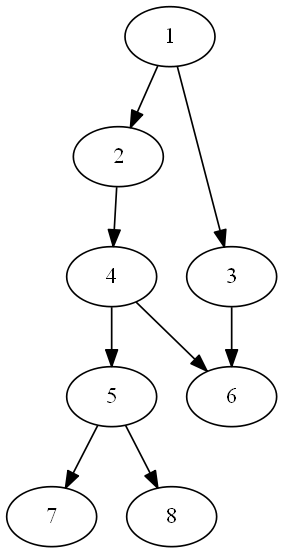

In [6]:
import networkx as nx
from nxpd import draw
G = nx.DiGraph()
G.graph['dpi'] = 120
G.add_nodes_from(range(1,9))
G.add_edges_from([(1,2),(1,3),(2,4),(3,6),(4,5),(4,6),(5,7),(5,8)])
draw(G, show='ipynb')
